## Import the libraries

In [1]:
import transformers
import json
import numpy as np
import tensorflow as tf
np.object = object

from datasets import Dataset
print(transformers.__version__)

2024-03-03 09:55:12.786707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 09:55:12.786805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 09:55:12.960580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


4.38.1


In [2]:
# specify the model name 
model_checkpoint = "distilbert-base-uncased"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Loading the dataset

In [3]:
import json

data_train = json.load(open("/kaggle/input/pii-detection-removal-from-educational-data/train.json"))

print(len(data_train))
print(data_train[0].keys())

6807
dict_keys(['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'])


In [4]:
labels_list = []
for sample in data_train:
    for label in sample['labels']:
        labels_list.append(label)

## Let's take a look at the distribution of the labels in the train set

In [5]:
labels_train = np.array(labels_list)
un,c = np.unique(labels_train, return_counts = True)

In [6]:
c

array([     39,      78,    1365,       6,       2,     110,       6,
             1,    1096,      15,      20,       1, 4989794])

In [7]:
pii = sum(c.tolist()[:-1])
non_pii =c[-1]

In [8]:
pii/non_pii

0.0005489204564356765

### The number of non personal information is not comparable so let's take a look at all the other labels

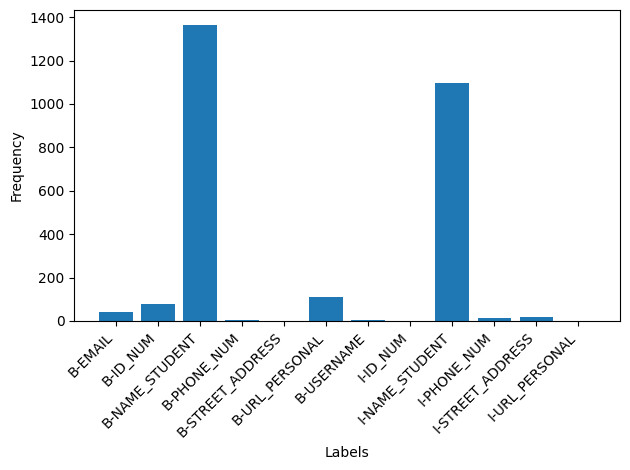

In [9]:
import matplotlib.pyplot as plt
# Plot histogram

plt.bar(un[:-1], c[:-1])
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent cropping
plt.show()


### Let's take a look at the distribution without the names

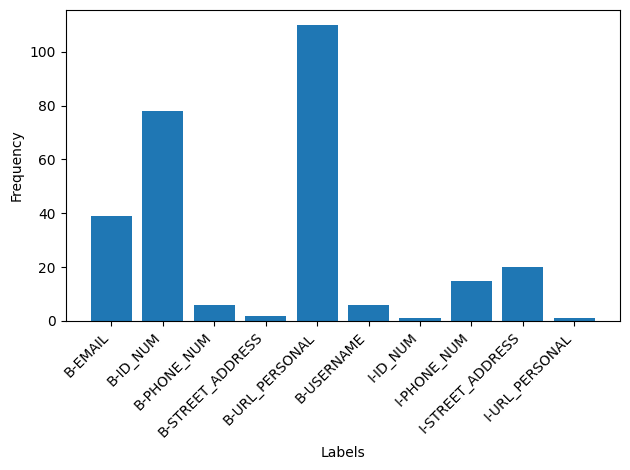

In [10]:
new_un = []
new_c = []
for (uni,co) in zip(un,c):
    if uni != 'B-NAME_STUDENT' and uni!= 'I-NAME_STUDENT' and uni!= 'O':
        new_un.append(uni)
        new_c.append(co)
plt.bar(new_un, new_c)
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent cropping
plt.show()

## Preprocessing the data

In [11]:
from transformers import AutoTokenizer, TFAutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
labels_set = set(np.array(labels_list))
labels_list = list(labels_set)
labels_list.sort()

label2id = {l:i for i,l in enumerate(labels_list)}
id2label = {v:k for k,v in label2id.items()}

# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [12]:
TRAINING_MAX_LENGTH = 512

In [13]:
label_all_tokens = True

In [14]:
from datasets import Dataset

train_ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data_train],
    "document": [x["document"] for x in data_train],
    "tokens": [x["tokens"] for x in data_train],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data_train],
    "provided_labels": [x["labels"] for x in data_train],
})

In [15]:
target = [
    'B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 
    'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM', 
    'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS', 'I-URL_PERSONAL'
]

# Tokenize the dataset

In [16]:
def tokenize(example, tokenizer, label2id):
    text = []

    # these are at the character level
    labels = []
    targets = []

    for t, l, ws in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):

        text.append(t)
        labels.extend([l]*len(t))

        if l in target:
            targets.append(1)
        else:
            targets.append(0)
        # if there is trailing whitespace
        if ws:
            text.append(" ")
            labels.append("O")

    tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=True, padding = 'max_length',max_length = 512, return_overflowing_tokens = True)

    target_num = sum(targets)
    labels = np.array(labels)


    text = "".join(text)
    token_labels = []
    for offset_seq in tokenized['offset_mapping']:
        token_labels_seq = []
        for start_idx, end_idx in offset_seq:
            is_special_token = False
            if start_idx == 0 and end_idx == 0: 
                is_special_token = True
                token_labels_seq.append(label2id["O"])
            if not is_special_token:
            # case when token starts with whitespace
                if text[start_idx].isspace():
                    start_idx += 1

                token_labels_seq.append(label2id[labels[start_idx]])
        token_labels.append(token_labels_seq)

    length = len(tokenized.input_ids)

    return {
        **tokenized,
        "labels": token_labels,
        "length": length,
        "target_num": target_num,
        "group": 1 if target_num>0 else 0
}

In [17]:
tokenized_ds = train_ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer, "label2id": label2id}, num_proc = 4)

#0:   0%|          | 0/1702 [00:00<?, ?ex/s]

#1:   0%|          | 0/1702 [00:00<?, ?ex/s]

#2:   0%|          | 0/1702 [00:00<?, ?ex/s]

#3:   0%|          | 0/1701 [00:00<?, ?ex/s]

## Split the dataset before removing the documents with no PII, in this way the validation set will also contain documents with no PII

In [18]:
train_validtest = tokenized_ds.train_test_split(test_size=0.2, seed = 42)

train_dataset = train_validtest['train']
validation_dataset = train_validtest['test']


## Removing the documents with no PII

In [19]:
exclude_idx = []
for i in range(len(train_dataset['group'])):
    if train_dataset['group'][i] == 0:
         exclude_idx.append(i)

# # create new dataset exluding those idx
train_dataset = train_dataset.select(
 (
     i for i in range(len(train_dataset)) 
     if i not in set(exclude_idx)
 )
)



## Fixing 'input_ids','labels', and 'attention_mask' to properly divide the sequences (if the sequence is 712 input_ids long) the sequences that will be processed are from 0-511 and 199-711.

In [20]:
def find_first_zero_index(lst):
    try:
        return lst.index(0)
    except ValueError:
        return -1


def set_last_sequence(row):
    n_seq = len(row['input_ids'])
    
    if n_seq >= 2:
        zero_index = find_first_zero_index(row['input_ids'][-1])
        if zero_index != -1:
        # fix input_ids 
            row['input_ids'][-1][-zero_index+1:] = row['input_ids'][-1][1:zero_index]
            row['input_ids'][-1][1:-zero_index+1] = row['input_ids'][-2][zero_index-1: -1]

        # fix labels
            row['labels'][-1][-zero_index+1:] = row['labels'][-1][1:zero_index]
            row['labels'][-1][1:-zero_index+1] = row['labels'][-2][zero_index-1 : -1]    

        # fix attention_mask
            row['attention_mask'][-1] = [1] * TRAINING_MAX_LENGTH
            
    
    return row 

train_dataset = train_dataset.map(set_last_sequence, num_proc=4)
validation_dataset = validation_dataset.map(set_last_sequence, num_proc=4)

#0:   0%|          | 0/188 [00:00<?, ?ex/s]

#1:   0%|          | 0/188 [00:00<?, ?ex/s]

#2:   0%|          | 0/188 [00:00<?, ?ex/s]

#3:   0%|          | 0/188 [00:00<?, ?ex/s]

#0:   0%|          | 0/341 [00:00<?, ?ex/s]

#1:   0%|          | 0/341 [00:00<?, ?ex/s]

#2:   0%|          | 0/340 [00:00<?, ?ex/s]

#3:   0%|          | 0/340 [00:00<?, ?ex/s]

## Tranforming the dataset into a pd dataframe to explode 'input_ids', 'attention_mask' and 'labels'

In [21]:
train_dataset.set_format('pandas')
validation_dataset.set_format('pandas')
train_dataset_df= train_dataset[:]
validation_dataset_df = validation_dataset[:]

In [22]:
train_dataset_df = train_dataset_df.explode(['input_ids', 'attention_mask', 'labels'])
validation_dataset_df = validation_dataset_df.explode(['input_ids', 'attention_mask', 'labels'])

In [23]:
train_dataset_df

,full_text,document,tokens,trailing_whitespace,provided_labels,input_ids,attention_mask,offset_mapping,overflow_to_sample_mapping,labels,length,target_num,group
0,Michael Ramirez (INDIA)\n\nVISUALIZATION\n\nEl...,12070,"[Michael, Ramirez, (, INDIA, ), \n\n, VISUALIZ...","[True, True, False, False, False, False, False...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[101, 2745, 15206, 1006, 2634, 1007, 5107, 398...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 7], [8, 15], [16, 17], [17, 22],...","[0, 0]","[12, 2, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12,...",2,2,1
0,Michael Ramirez (INDIA)\n\nVISUALIZATION\n\nEl...,12070,"[Michael, Ramirez, (, INDIA, ), \n\n, VISUALIZ...","[True, True, False, False, False, False, False...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[101, 2030, 20694, 2135, 1007, 1012, 2009, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 7], [8, 15], [16, 17], [17, 22],...","[0, 0]","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",2,2,1
1,Teresa’s Reflection- Mind Mapping Challenge ...,4816,"[Teresa, ’s, Reflection-, Mind, Mapping, , Ch...","[False, True, True, True, True, False, True, F...","[B-NAME_STUDENT, O, O, O, O, O, O, O, O, O, O,...","[101, 12409, 1521, 1055, 9185, 1011, 2568, 123...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 6], [6, 7], [7, 8], [9, 19], [19...","[0, 0]","[12, 2, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12...",2,1,1
1,Teresa’s Reflection- Mind Mapping Challenge ...,4816,"[Teresa, ’s, Reflection-, Mind, Mapping, , Ch...","[False, True, True, True, True, False, True, F...","[B-NAME_STUDENT, O, O, O, O, O, O, O, O, O, O,...","[101, 1521, 1055, 8466, 4089, 1998, 23216, 206...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 6], [6, 7], [7, 8], [9, 19], [19...","[0, 0]","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",2,1,1
2,DESIGN THINKING ASSINGMENT\n\nDARDEN BUSINESS ...,6946,"[DESIGN, THINKING, ASSINGMENT, \n\n, DARDEN, B...","[True, True, False, False, True, True, True, T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[101, 2640, 3241, 4632, 2075, 3672, 18243, 418...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 6], [7, 15], [16, 19], [19, 22],...","[0, 0, 0]","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,Bruno Milani Challenge – How might we culti...,7265,"[Bruno, Milani, , Challenge, –, How, might,...","[True, True, False, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[101, 10391, 6954, 2072, 4119, 1516, 2129, 245...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 5], [6, 11], [11, 12], [16, 25],...","[0, 0, 0]","[12, 2, 8, 8, 12, 12, 12, 12, 12, 12, 12, 12, ...",3,2,1
750,Bruno Milani Challenge – How might we culti...,7265,"[Bruno, Milani, , Challenge, –, How, might,...","[True, True, False, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[101, 10800, 1999, 2733, 1016, 4541, 1010, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 5], [6, 11], [11, 12], [16, 25],...","[0, 0, 0]","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",3,2,1
750,Bruno Milani Challenge – How might we culti...,7265,"[Bruno, Milani, , Challenge, –, How, might,...","[True, True, False, True, True, True, True, Tr...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[101, 5669, 2026, 8312, 2059, 2044, 8902, 7485...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[[0, 0], [0, 5], [6, 11], [11, 12], [16, 25],...","[0, 0, 0]","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",3,2,1
751,REFLECTION Mind Mapping\n\nBy Muhammad Leonar...,7929,"[REFLECTION, , Mind, Mapping, \n\n, By, Muham...","[True, False, True, False, False, True, True, ...","[O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUD...","[101, 9185, 2568, 12375, 2011, 7187, 14720, 41...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [24]:
print(len(train_dataset_df))
print(len(validation_dataset_df))

1569
2567


In [25]:
train_ds = Dataset.from_pandas(train_dataset_df)
val_ds = Dataset.from_pandas(validation_dataset_df)

In [26]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, num_labels=len(labels_list), id2label=id2label, label2id=label2id
)
data_collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=8)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
!pip install seqeval evaluate -q

# Define the metrics

In [28]:

from seqeval.metrics import recall_score, precision_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score

def compute_metrics(p, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    recall = recall_score(true_labels, true_predictions)
    precision = precision_score(true_labels, true_predictions)
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = (1 + 5*5) * recall * precision / (5*5*precision + recall)
    
    results = {
        'recall': recall,
        'precision': precision,
        'f1': f1_score
    }
    return results

# Define the trainer to train the model

In [30]:
from functools import partial
from transformers import EarlyStoppingCallback
early_stop = EarlyStoppingCallback(10, 0.01)
args = TrainingArguments(
    output_dir='output', 
    fp16=True, # mixed precision
    learning_rate=1e-5,
    num_train_epochs=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    overwrite_output_dir=True,
    load_best_model_at_end=True,
    lr_scheduler_type='cosine',
    metric_for_best_model="f1",
    greater_is_better=True,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model, 
    args=args, 
    train_dataset=train_ds, 
    eval_dataset=val_ds, 
    data_collator=data_collator, 
    tokenizer=tokenizer,
    compute_metrics=partial(compute_metrics, all_labels=labels_list),
    callbacks=[early_stop]
)

In [31]:
import torch
torch.cuda.empty_cache()

In [32]:
%%time

trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Recall,Precision,F1
1,No log,0.012603,0.000000,0.000000,0
2,No log,0.005258,0.519106,0.342043,0.508972
3,No log,0.004378,0.723864,0.426146,0.704923
4,No log,0.003666,0.675559,0.465706,0.664050
5,No log,0.003285,0.737563,0.537008,0.727119
6,No log,0.004022,0.842105,0.491376,0.819605
7,No log,0.003973,0.815429,0.517383,0.797754
8,No log,0.003792,0.828407,0.533674,0.811176
9,No log,0.004681,0.820476,0.521062,0.802735
10,0.052400,0.004055,0.780101,0.586450,0.770318


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead

CPU times: user 2h 16min 33s, sys: 2min 27s, total: 2h 19min
Wall time: 2h 15min 53s


TrainOutput(global_step=4950, training_loss=0.0053679796826150835, metrics={'train_runtime': 8153.0056, 'train_samples_per_second': 19.244, 'train_steps_per_second': 0.613, 'total_flos': 2.029851311989248e+16, 'train_loss': 0.0053679796826150835, 'epoch': 99.0})

In [33]:
trainer.save_model('giannilbert')

In [34]:
tokenizer.save_pretrained('giannitokenizer')

('giannitokenizer/tokenizer_config.json',
 'giannitokenizer/special_tokens_map.json',
 'giannitokenizer/vocab.txt',
 'giannitokenizer/added_tokens.json',
 'giannitokenizer/tokenizer.json')